In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans

sns.set(color_codes=True)

C:\Users\antoi\anaconda3\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


# Récupération des données

### On récupère les données de consommation des batiments appartenant aux ministères de :
* l'Interieur
* l'Education
* la Finance
* la Justice

Consommation par heure (moyenne de 6 mesures)

In [7]:
df_conso_hour = pd.read_csv('C:/Users/antoi/Documents/SCIA/hackaton/conso_int_edu_fin_justice.csv', sep=';')
df_conso_hour['RAE'] = df_conso_hour['RAE'].astype(str)
df_conso_hour["Date"] = pd.to_datetime(df_conso_hour["Date"])
df_conso_hour = df_conso_hour[df_conso_hour.Date.dt.year == 2014]

In [8]:
df_conso_hour.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2198760 entries, 0 to 2200943
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   RAE     object        
 1   Date    datetime64[ns]
 2   kWh     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 67.1+ MB


In [11]:
df_conso_hour.sample(10)

,RAE,Date,kWh
1390223,30000510086448,2014-06-15 00:00:00,117.500000
229491,50027785809597,2014-02-17 03:00:00,464.000000
1303235,30000240236190,2014-10-07 12:00:00,74.000000
1951768,30001421039552,2014-07-22 17:00:00,196.333333
1204881,30002254007118,2014-04-18 10:00:00,102.166667
1586599,30001912923956,2014-11-14 07:00:00,328.833333
1990879,30001441414542,2014-08-01 07:00:00,303.833333
1909715,30002510423197,2014-03-10 12:00:00,115.166667
1538475,30000950042884,2014-05-18 04:00:00,214.000000
1005353,30001611321283,2014-08-07 18:00:00,348.000000


In [9]:
df_label_batiments = pd.read_csv("C:/Users/antoi/Documents/SCIA/hackaton/type_batiments.csv", sep=",", encoding='utf-8')
df_label_batiments['RAE'] = df_label_batiments['RAE'].astype(str)

In [10]:
df_label_batiments.sample(10)

,RAE,Ministere (Client),NOM DU SITE,Label,ADRESSE,CODE POSTAL,VILLE
24,30000510086448,JUSTICE,CENTRE DE DETENTION TOUL,Prison,804 RUE DU MARECHAL LYAUTEY 54200 TOUL,54200,TOUL
89,30001550414113,INTERIEUR,SCE DE DIFFUSION GENDARMERIE,Service,RUE PAUL CLAUDEL,87000,LIMOGES
82,30001460025099,JUSTICE,M JUSTICE MAISON D ARRET,Prison,171 RUE DU GENERAL PAULET 29200 BREST,29200,BREST
120,30001912923956,Ministďż˝res ďż˝conomiques et financiers,ETAB DE SERVICES INFORMATIQUES,IT,1 AVENUE DOCTEUR SCHWEITZER,69330.0,MEYZIEU
71,30001420776403,JUSTICE,M. JUSTICE - CENTRE PENITENTIAIRE,Prison,68 BOULEVARD ALBERT EINSTEIN 44300 NANTES,44300,NANTES
51,30000731156801,EDUCATION,EDUCATION NATIONALE,Ministere,99 RUE DE GRENELLE,75007,PARIS 07
70,30001420762021,Ministďż˝res ďż˝conomiques et financiers,I N S E E,Administration,105 RUE DES FRANCAIS LIBRES,44200.0,NANTES
230,30002524096202,JUSTICE,ANNEXE DU TRIBUNAL DE GRANDE INSTANCE D AIX EN...,Tribunal,IMPASSE DES FRERES PRATESI 13090 AIX EN PROVENCE,13090,AIX EN PROVENCE
209,30002430739747,JUSTICE,NOUVEAU PALAIS DE JUSTICE,Tribunal,PLACE PIERRE FLOTTE 34000 MONTPELLIER,34000,MONTPELLIER
242,30002590707766,JUSTICE,PALAIS DE JUSTICE DE GRASSE,Tribunal,37 AVENUE PIERRE SEMARD 06130 GRASSE,6130,GRASSE


### Liste des batiments des ministères avec le nom du site
=> Création de label à partir des noms

In [11]:
df_label_batiments.Label.unique()
# Expliquer les noms (IT : services infos)

array(['Tribunal', 'Administration', 'Ecole', 'Service', 'Commissariat',
       'Prison', 'Ministere', 'Caserne', 'Unknown', 'IT'], dtype=object)

### Croisement entre les mesures et les infos du batiments (via l'id RAE)

In [12]:
df_pivot = df_conso_hour.merge(df_label_batiments[["RAE", "Ministere (Client)", "NOM DU SITE", "Label", "ADRESSE", "CODE POSTAL", "VILLE"]],
                         left_on="RAE", right_on="RAE", how="left")
df_pivot.sample(5)

,RAE,Date,kWh,Ministere (Client),NOM DU SITE,Label,ADRESSE,CODE POSTAL,VILLE
1090754,30002311160384,2014-08-07 03:00:00,5.500000,JUSTICE,REIP - MURET,Unknown,ROUTE DE SEYSSES,31600,MURET
192181,30000111964901,2014-09-12 13:00:00,289.000000,INTERIEUR,PREFECTURE DU NORD,Service,RUE DE L HOPITAL MILITAIRE,59800,LILLE
932254,30001612459410,2014-03-06 23:00:00,75.333333,EDUCATION,RECTORAT BORDEAUX MERIADECK,Ecole,114 RUE GEORGES BONNAC,33000,BORDEAUX
1218515,30000220299483,2014-06-02 11:00:00,632.333333,JUSTICE,JUSTICE- VAL DE REUIL- MAISON D'ARRET (02994),Prison,LES VIGNETTES 27100 VAL DE REUIL,27100,VAL DE REUIL
1517798,30001630205962,2014-07-04 15:00:00,139.833333,JUSTICE,MIN JUS - DAP -BX – CD EYSSES,Administration,1 RUE PIERRE DOIZE BP 315 47300 VILLENEUVE SUR...,47300,VILLENEUVE SUR LOT


## Fonctions utilitaires

Graphe de la consommation d'un batiment par (an, mois, semaine...)

In [13]:
sns.set(rc={'figure.figsize':(16, 6)})
def plot_consumption(df, rae_filter, datetime_filter, datetime_value=None):
    # df : df_pivot
    
    df_rae = df[df.RAE == rae_filter]
    
    if datetime_filter == "year":
        df_final = df_rae
    elif datetime_filter == "month":
        df_final = df_rae[df_rae.Date.dt.month == datetime_value]
    elif datetime_filter == "week":
        df_final = df_rae[df_rae.Date.dt.weekofyear == datetime_value]
    else:
        df_final = df_rae[df_rae.Date.dt.dayofyear == datetime_value]
    
    sns.lineplot(x="Date", y="kWh", hue="RAE", data=df_final).set_title(
                                f"Consumption of {df_rae['NOM DU SITE'].values[0]} in a {datetime_filter}")

In [14]:
# Graphe de plusieurs batiments selon un label
def subplot_consumption_types(df_labels, df_data, label, date_filters):
    i = 1
    
    plt.subplots_adjust(hspace=0.5)
    for rae in df_labels[df_labels.Label == label].sample(4, random_state=42).RAE:
        plt.subplot(2, 2, i)   
        plot_consumption(df_data, rae, *date_filters)
        
        i+=1

## Quelques exemples de consommation électrique

<ipython-input-13-9a2e5c3120c9>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_final = df_rae[df_rae.Date.dt.weekofyear == datetime_value]
<ipython-input-13-9a2e5c3120c9>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_final = df_rae[df_rae.Date.dt.weekofyear == datetime_value]
<ipython-input-13-9a2e5c3120c9>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_final = df_rae[df_rae.Date.dt.weekofyear == datetime_value]
<ipython-input-13-9a2e5c3120c9>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_final = df_rae[df_rae.Date.dt.weekofyear == datetime_value]


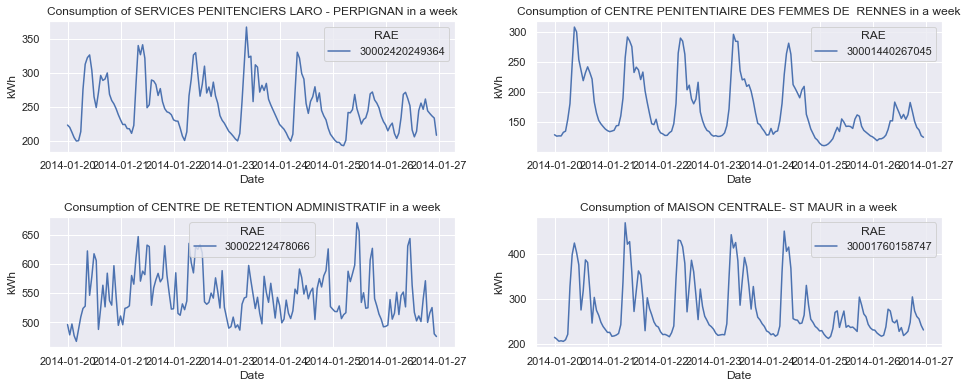

In [15]:
subplot_consumption_types(df_label_batiments, df_pivot, "Prison", ("week", 4))

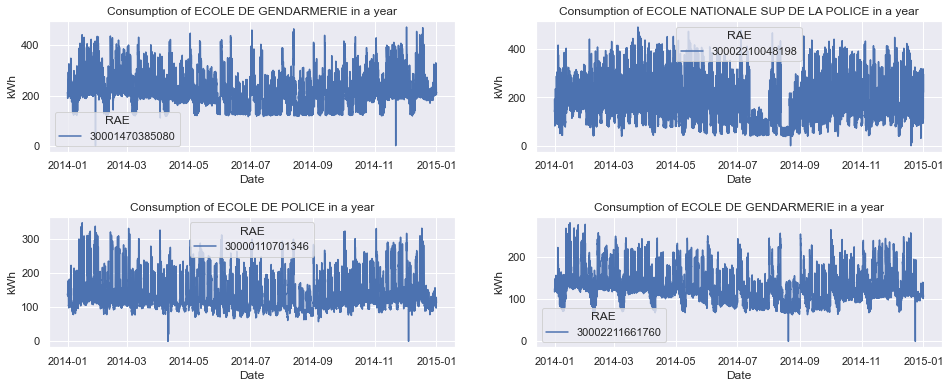

In [16]:
subplot_consumption_types(df_label_batiments, df_pivot, "Ecole", ("year", 0))

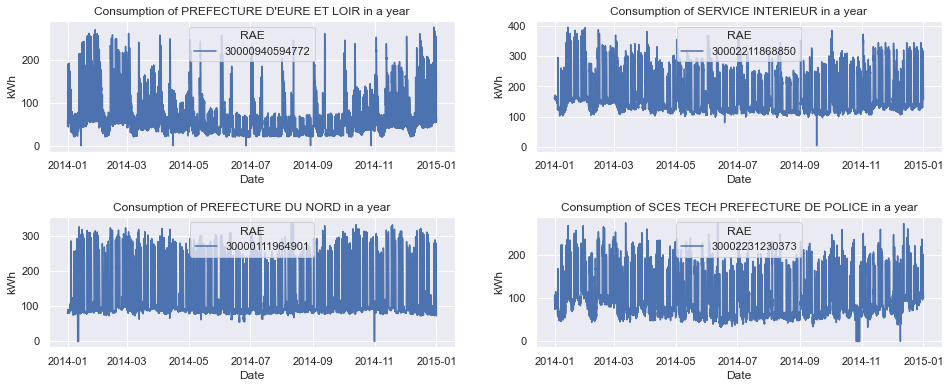

In [17]:
subplot_consumption_types(df_label_batiments, df_pivot, "Service", ("year", 0))

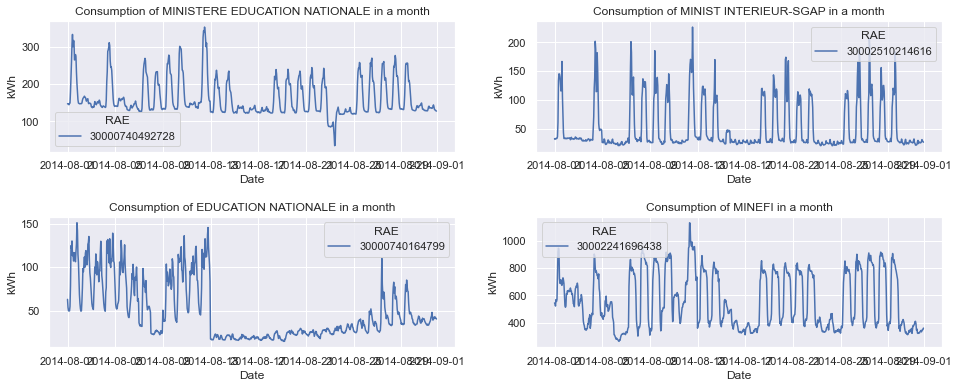

In [18]:
subplot_consumption_types(df_label_batiments, df_pivot, "Ministere", ("month", 8))

# Distance DTW

## Clustering

### Normalisons les données

In [19]:
def get_mean_by_day(df=df_pivot, normalize=True):
    """
    Returns :
    X : list par batiment de consommation pour chaque jour de l'année
    y : list du RAE (id du batiment) dans le meme ordre que X
    """
    RAEs = df.RAE.unique()
    df = df.sort_values(by="Date", ascending=True)

    y = []
    x = []

    for i in tqdm(range(len(RAEs))):
        df_rae = df[df.RAE == RAEs[i]]

        x.append([
            df_rae[df_rae.Date.dt.dayofyear == d]["kWh"].sum()/24
            for d in df_rae.Date.dt.dayofyear.unique()
        ])
        y.append(RAEs[i])

            
    X = np.vstack(x)
    if normalize:
        X = X / X.sum(axis = 1).reshape(-1, 1)
    return X, y

In [20]:
X, y = get_mean_by_day(df_pivot)

100%|██████████| 250/250 [03:03<00:00,  1.37it/s]


### Recherche du K optimal pour le clustering

In [23]:
from kneed import KneeLocator

In [24]:
inertias = []
for k in tqdm(range(2, 20)):
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw",
                         max_iter=100, random_state=42)
    model.fit(X)
    inertias.append(model.inertia_)

100%|██████████| 18/18 [37:06<00:00, 123.69s/it]


Optimal number of clusters 6


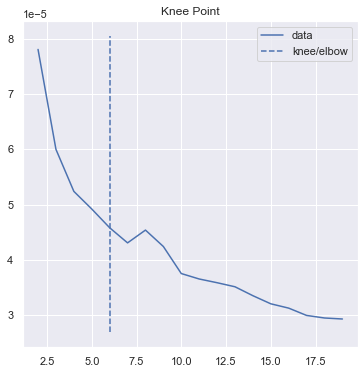

In [25]:
kneedle = KneeLocator(np.arange(2, 20), inertias, S=1.0, curve='convex', direction="decreasing")
print("Optimal number of clusters", kneedle.knee)
kneedle.plot_knee()

In [26]:
model = TimeSeriesKMeans(n_clusters=6, metric="dtw",
                         max_iter=100, random_state=42)
model.fit(X)
model.inertia_

4.584197327953322e-05

In [29]:
batiment_indexes = [df_pivot[df_pivot.RAE == rae].index[0] for rae in y]
df_examples = df_pivot.loc[batiment_indexes][["RAE", "Ministere (Client)", "NOM DU SITE", "ADRESSE", "CODE POSTAL", "VILLE"]]
df_examples

,RAE,Ministere (Client),NOM DU SITE,ADRESSE,CODE POSTAL,VILLE
0,30001611990181,INTERIEUR,INTERIEUR SGAP BX,RUE FRANCOIS DE SOURDIS,33000,BORDEAUX
8760,30001750381272,INTERIEUR,DEFENSE CASERNE LA BACHELLERIE,LA BACHELLERIE SUD,19000,TULLE
17520,30000741696020,INTERIEUR,PREFECTURE DE PARIS,5 RUE LEBLANC,75511,PARIS 15
26280,30001444910479,INTERIEUR,CENTRE NATIONAL DE TRAITEMENT - ANTAI RENNES,2 ALLEE ERMENGARDE D'ANJOU - ZAC ATALANTE CHAM...,35000,RENNES
35040,30001470385080,INTERIEUR,ECOLE DE GENDARMERIE,TY VOUGERET,29150,DINEAULT
...,...,...,...,...,...,...
2154960,30000730520308,Ministďż˝res ďż˝conomiques et financiers,MINISTERE DE L ECONOMIE ET DES FINANCES,59 BOULEVARD VINCENT AURIOL,75013.0,PARIS 13
2163720,30001910275386,Ministďż˝res ďż˝conomiques et financiers,DIRECTION DES SERVICES INFORMA,5 PETITE RUE DE MONPLAISIR,69008.0,LYON
2172480,30000720645041,Ministďż˝res ďż˝conomiques et financiers,MEFI - DGI - DSIP (072-06450),RUE REYNALDO HAHN,75020.0,PARIS 20
2181240,30002210153937,Ministďż˝res ďż˝conomiques et financiers,DISI PARIS CHAMPAGNE-NEMOURS,22 AVENUE JOHN KENNEDY,77140.0,NEMOURS


In [30]:
df_examples["Cluster"] = model.labels_
model.labels_

array([5, 0, 1, 0, 0, 4, 0, 2, 5, 0, 4, 4, 4, 0, 2, 2, 0, 0, 0, 0, 2, 1,
       0, 1, 5, 5, 0, 2, 5, 0, 1, 0, 2, 5, 0, 2, 2, 0, 0, 0, 0, 2, 1, 0,
       2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 5, 0, 1, 2, 0, 5, 2, 2, 0, 0, 2, 2,
       0, 2, 0, 2, 2, 1, 0, 0, 0, 0, 2, 4, 0, 0, 1, 2, 2, 5, 0, 0, 0, 2,
       3, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 5, 1, 1, 0, 5, 1, 0, 2, 5, 0, 0,
       0, 0, 0, 1, 0, 5, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 5, 0, 5,
       5, 0, 4, 0, 5, 1, 1, 0, 0, 1, 2, 0, 5, 0, 4, 2, 0, 0, 0, 1, 2, 2,
       5, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1, 0, 0, 2, 0, 0, 2, 2, 0, 0,
       0, 2, 5, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 5, 0, 0, 2, 5, 1, 5, 5, 1,
       5, 1, 2, 5, 1, 1, 5, 0, 1, 4, 0, 1, 0, 1, 1, 0, 5, 0, 0, 0, 0, 2,
       2, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 2, 0, 5, 1, 0, 0, 2, 2, 1, 1, 0,
       4, 5, 5, 5, 0, 1, 0, 0], dtype=int64)

In [44]:
def show_sample_cluster(df=df_examples, cluster_id=0):
    
    for i in np.where(model.labels_ == cluster_id)[0]:
        plt.plot(np.arange(X.shape[1]), X[i, :])
        
    return df_examples[df_examples.Cluster == cluster_id].sample(10)

,RAE,Ministere (Client),NOM DU SITE,ADRESSE,CODE POSTAL,VILLE,Cluster
2119920,30000710011902,Ministďż˝res ďż˝conomiques et financiers,PAIERIE GENERALE DU TRESOR,16 RUE NOTRE DAME DES VICTOIRES,75002.0,PARIS 02,0
35040,30001470385080,INTERIEUR,ECOLE DE GENDARMERIE,TY VOUGERET,29150,DINEAULT,0
1848360,30002210189914,Ministďż˝res ďż˝conomiques et financiers,CITE ADMINISTRATIVE,BOULEVARD CHAMBLAIN,77000.0,MELUN,0
1314000,30001710344444,JUSTICE,CD DE RIOM,17 RUE SOUBRANY 63200 RIOM,63200,RIOM,0
735840,30000730095486,INTERIEUR,PREFECTURE DE POLICE SCES TECH,4 RUE JULES BRETON,75013,PARIS 13,0
1541760,30001520492148,Ministďż˝res ďż˝conomiques et financiers,DIRECTION GENERALE DES DOUANES,1730 1 RUE DU JURA,17000.0,LA ROCHELLE,0
1077480,30001930387556,JUSTICE,PRISON-M.A. DE GRENOBLE,. 38760 VARCES ALLIERES ET RISSET,38760,VARCES ALLIERES ET RISSET,0
297840,30000454023641,INTERIEUR,MINISTERE DE L INTERIEUR,18 RUE DES GAYETTES,10000,TROYES,0
1182600,30000550073553,JUSTICE,CENTRE DE DETENTION OERMINGEN,. 67970 OERMINGEN,67970,OERMINGEN,0
508080,30002511086807,INTERIEUR,COMMISSARIAT DE NOAILLES,BOULEVARD GARIBALDI,13001,MARSEILLE 01,0


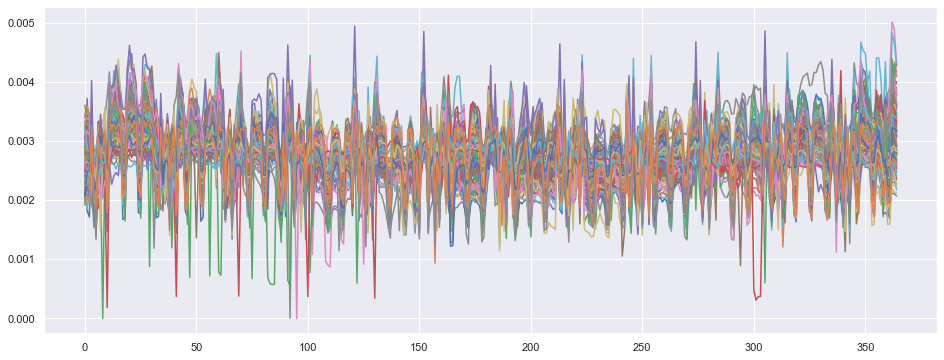

In [45]:
show_sample_cluster(cluster_id=0)

,RAE,Ministere (Client),NOM DU SITE,ADRESSE,CODE POSTAL,VILLE,Cluster
621960,30002121767618,INTERIEUR,Service,5 AVENUE BERNARD HIRSCH - CS 105,95010,CERGY PONTOISE CX,1
183960,30000111964901,INTERIEUR,PREFECTURE DU NORD,RUE DE L HOPITAL MILITAIRE,59800,LILLE,1
1962240,30001910545277,Ministďż˝res ďż˝conomiques et financiers,CITE ADMNISTRATIVE ETAT,165 RUE GARIBALDI,69003.0,LYON 03,1
1603080,30001710280321,Ministďż˝res ďż˝conomiques et financiers,HOTEL DES IMPOTS,65 BOULEVARD BERTHELOT,63400.0,CHAMALIERES,1
911040,30002130027724,EDUCATION,MAISON DES EXAMENS ARCUEIL,7 RUE ERNEST RENAN,94110,ARCUEIL,1
438000,30000730184913,INTERIEUR,MINISTERE DES OUTRE MER,27 RUE OUDINOT,75007,PARIS 07,1
1857120,30002531902351,Ministďż˝res ďż˝conomiques et financiers,CITE ADMINISTRATIVE 0000,13 RUE DE LORGUES,83000.0,TOULON,1
876000,30000731156801,EDUCATION,EDUCATION NATIONALE,99 RUE DE GRENELLE,75007,PARIS 07,1
1787040,30002580159329,Ministďż˝res ďż˝conomiques et financiers,DIRECTION DES IMPOTS PACA - AVIGNON* DIR SVCES...,COURS JEAN JAURES,84000.0,AVIGNON,1
429240,30001550451231,INTERIEUR,POLICE NATIONALE - ECLPN - CONTRAT CRAEM,ZI BUXEROLLES,87000,LIMOGES,1


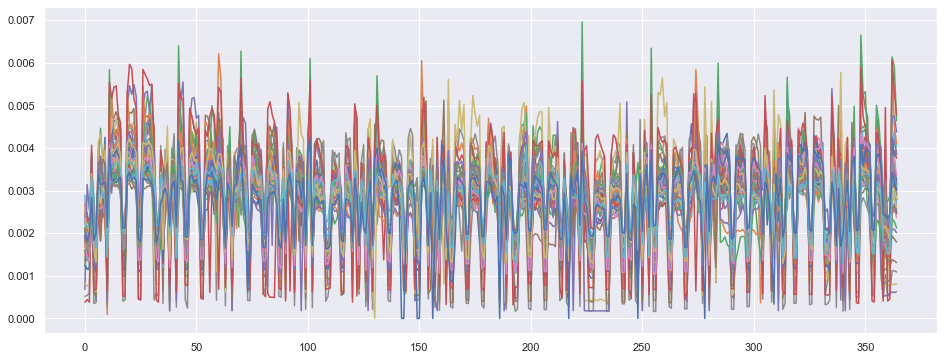

In [46]:
show_sample_cluster(cluster_id=1)

,RAE,Ministere (Client),NOM DU SITE,ADRESSE,CODE POSTAL,VILLE,Cluster
709560,30002111076090,INTERIEUR,LEGION GENDARMERIE MOBILE IDF,ROUTE DE FRILEUSE,78650,BEYNES,2
534360,30000210767697,INTERIEUR,PREFECTURE,RUE DU CONTRAT SOCIAL,76000,ROUEN,2
315360,30002530120483,INTERIEUR,UNITE D'INSTRUCTION ET D'INTERVENTION SECURITE...,QUARTIER DE RAMATUELLE,83170,BRIGNOLES,2
1515480,30001630205962,JUSTICE,MIN JUS - DAP -BX – CD EYSSES,1 RUE PIERRE DOIZE BP 315 47300 VILLENEUVE SUR...,47300,VILLENEUVE SUR LOT,2
175200,30001550350438,INTERIEUR,MINISTERE DE L'INTERIEUR,41 RUE BARTHELEMY THIMONNIER,87280,LIMOGES,2
1436640,30002141147778,JUSTICE,MINISTERE DE LA JUSTICE,2 RUE PABLO NERUDA 92000 NANTERRE,92000,NANTERRE,2
1585560,30002251811552,Ministďż˝res ďż˝conomiques et financiers,MEFI - DGI - DVNI - PANTIN (225-18115),6 B RUE COURTOIS,93500.0,PANTIN,2
2093640,30002311860907,Ministďż˝res ďż˝conomiques et financiers,DIRECTION DES SERVICES FISCAUX,RUE DE L ESQUILE,31000.0,TOULOUSE,2
928560,30001612459410,EDUCATION,RECTORAT BORDEAUX MERIADECK,114 RUE GEORGES BONNAC,33000,BORDEAUX,2
560640,30002110514509,INTERIEUR,GENDARMERIE MOBILE,QUARTIER MONCEY GM ATELIERS,78000,VERSAILLES,2


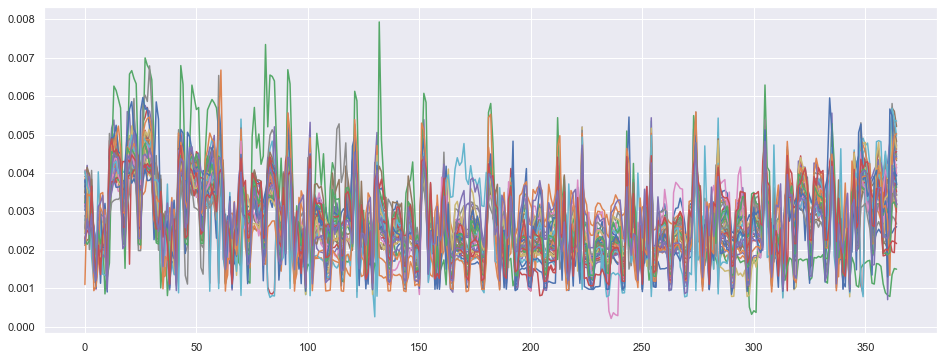

In [47]:
show_sample_cluster(cluster_id=2)

### Interprétation

Le clustering ne nous donne pas de résultat satisfaisant.  
En effet, on retrouve des bâtiments de tout type dans chacun des clusters ce qui laisse penser que le type de bâtiment ne semble pas avoir de lien particulier avec sa consommation électrique.

In [51]:
%matplotlib notebook
custom_palette = sns.color_palette("hls", 9)
colors = [custom_palette[label] for label in model.labels_]

for i in range(len(X)):
    plt.title('Consommation par cluster')
    plt.plot(np.arange(X.shape[1]), X[i, :], alpha=0.5, c=colors[i])

<IPython.core.display.Javascript object>

## Distance inter type

On va utiliser les différents labels associés aux bâtiments afin de calculer la distance (DTW) qui les séparent.  
L'objectif est d'essayer de voir si certains type de bâtiments sont vraiment différents du point de vu de la consommation electrique.  

In [52]:
# Mesure de la distance (https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd)
from tslearn.metrics import dtw

In [53]:
# Recup la moyenne de conso par jour normalisée par la conso annuelle par batiment
def get_data_by_rae(df=df_pivot, normalize=True, RAEs=df_pivot.RAE.unique()):
    """
    Returns :
    X : list par batiment de consommation pour chaque jour de l'année
    y : list du RAE (id du batiment) dans le meme ordre que X
    """
    df = df.sort_values(by="Date", ascending=True)
    
    y = []
    x = []

    for i in tqdm(range(len(RAEs))):
        df_rae = df[df.RAE == RAEs[i]]

        x.append([
            df_rae[df_rae.Date.dt.dayofyear == d]["kWh"].sum()/24
            for d in df_rae.Date.dt.dayofyear.unique()
        ])
        y.append(RAEs[i])
            
    X = np.vstack(x)
    if normalize:
        X = X / X.sum(axis = 1).reshape(-1, 1)
    return X, y

In [54]:
# Calcule la distance en les conso des batiments selectionnés
def compute_inter_distance(df=df_pivot, selected_rae=df_pivot.RAE.unique()):    
    X, y = get_data_by_rae(df_pivot, RAEs=selected_rae)

    dist = []
    for i in tqdm(range(len(X))):
        for j in range(i+1, len(X)):
            dist.append(dtw(X[i], X[j]))
    
    
    return dist

On va prendre des bâtiments qui sont, à première vue, bien différents: prisons et école.

In [55]:
rae_prisons = df_label_batiments[df_label_batiments.Label == "Prison"].RAE.values
dist_inter_prisons = compute_inter_distance(df_pivot, rae_prisons)
print("Distance DTW moyenne entre les prisons (conso annuelle) : {:.2e}".format(np.mean(dist_inter_prisons)))

100%|██████████| 32/32 [00:02<00:00, 14.75it/s]

Distance DTW moyenne entre les prisons (conso annuelle) : 8.36e-03


In [56]:
rae_ecoles = df_label_batiments[df_label_batiments.Label == "Ecole"].RAE.values
dist_inter_ecoles = compute_inter_distance(df_pivot, rae_ecoles)
print("Distance DTW moyenne entre les écoles (conso annuelle) : {:.2e}".format(np.mean(dist_inter_ecoles)))

100%|██████████| 24/24 [00:01<00:00, 20.04it/s]

Distance DTW moyenne entre les écoles (conso annuelle) : 8.38e-03


In [57]:
X_e, y_e = get_data_by_rae(df_pivot, RAEs=rae_ecoles)
X_p, y_p = get_data_by_rae(df_pivot, RAEs=rae_prisons)

dist = []
for i in tqdm(range(len(X_e))):
    for x_p in X_p:
        dist.append(dtw(X_e[i], x_p))

print("Distance DTW moyenne entre les prisons et les écoles : {:.2e}".format(np.mean(dist)))

100%|██████████| 24/24 [00:03<00:00,  7.16it/s]

Distance DTW moyenne entre les prisons et les écoles : 9.52e-03


La distance entre les prisons et les écoles (par jours) est de 0.0095 en moyenne.  
Ces deux bâtiments ne sont donc pas vraiment différents du point de vu de leur consommation électrique.